In [1]:
import pandas as pd
import numpy as np

ohlc_path = "/home/mimus/qlearning/data/sources/candles/binance/BINANCE_BTCUSDT.historic_prices_5m.json"
ew_path = "/home/mimus/qlearning/data/sources/ew/binance/BINANCE_BTCUSDT.strategies_5_t5001.json"

ohlc_df = pd.read_json(ohlc_path)
ohlc_df=ohlc_df[["ts","o","h","l", "c"]].iloc[0:-286]#hay que cambiar esto para que se usen los ts en lugar de estas cosas raras
ohlc_df=ohlc_df.reset_index(drop=True)
ew_df = pd.read_json(ew_path)
ew_df=ew_df.sort_values(by=['ts']).iloc[1:].reset_index(drop=True)

In [2]:
merged_df= pd.merge(ohlc_df, ew_df, on='ts', how='left')
merged_df.fillna(0, inplace=True)
merged_df.to_csv("data/training/5m_train_qlearning.csv")


In [2]:
ohlc_df


,ts,o,h,l,c
0,1567970100,10345.41,10352.97,10345.41,10349.19
1,1567970400,10349.19,10357.53,10345.45,10346.19
2,1567970700,10346.19,10354.62,10342.90,10354.62
3,1567971000,10354.62,10357.35,10344.33,10346.00
4,1567971300,10346.00,10347.09,10340.34,10341.14
...,...,...,...,...,...
426869,1696030800,26898.60,26898.70,26896.20,26896.20
426870,1696031100,26896.20,26906.00,26892.60,26905.90
426871,1696031400,26905.90,26908.20,26892.40,26892.50
426872,1696031700,26892.50,26897.60,26890.90,26890.90


In [1]:
import pandas as pd
import numpy as np

ohlc_path = "/home/mimus/qlearning/data/sources/candles/binance/BINANCE_BTCUSDT.historic_prices_5m.json"

df = pd.read_json(ohlc_path)
df=df[["ts","o","h","l", "c"]].iloc[0:-286]#hay que cambiar esto para que se usen los ts en lugar de estas cosas raras

In [3]:
import pandas as pd
import numpy as np

# Suponiendo que tu DataFrame se llama df y tiene las columnas 'ts', 'o', 'h', 'l', 'c'

# Función para calcular los retornos logarítmicos
def log_return(series1, series2):
    return np.log(series1 / series2)

# Calcular retornos logarítmicos para open/close y low/high
df['log_ret_oc'] = log_return(df['o'], df['c'])
df['log_ret_lh'] = log_return(df['l'], df['h'])

# Calcular las Bandas de Bollinger
def bollinger_bands(series, window=20, num_of_std=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, rolling_mean, lower_band

df['bb_upper'], df['bb_middle'], df['bb_lower'] = bollinger_bands(df['c'])

# Calcular RSI
def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    ema_up = up.ewm(com=period - 1, adjust=False).mean()
    ema_down = down.ewm(com=period - 1, adjust=False).mean()

    rs = ema_up / ema_down
    return 100 - (100 / (1 + rs))

df['rsi'] = rsi(df['c'])

# Calcular MACD
def macd(series, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = series.ewm(span=fast_period, adjust=False).mean()
    ema_slow = series.ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

df['macd'], df['macd_signal'], df['macd_hist'] = macd(df['c'])

# Normalizar las nuevas características (excepto 'ts', 'o', 'h', 'l', 'c')
features_to_normalize = ['log_ret_oc', 'log_ret_lh', 'bb_upper', 'bb_middle', 'bb_lower', 'rsi', 'macd', 'macd_signal', 'macd_hist']
df[features_to_normalize] = (df[features_to_normalize] - df[features_to_normalize].mean()) / df[features_to_normalize].std()
df=df.iloc[20:]
# Mostrar las primeras filas del DataFrame modificado
print(df.head())


            ts         o         h         l         c  log_ret_oc  \
20  1567976100  10339.18  10352.63  10334.54  10351.42   -0.513666   
21  1567976400  10351.42  10353.97  10343.74  10343.74    0.323813   
22  1567976700  10343.74  10345.91  10325.62  10331.00    0.537046   
23  1567977000  10331.00  10334.76  10328.19  10329.80    0.051501   
24  1567977300  10329.80  10330.70  10324.77  10330.70   -0.036923   

    log_ret_lh  bb_upper  bb_middle  bb_lower       rsi      macd  \
20    0.299750 -1.046851  -1.045155 -1.043306 -0.494600  0.001152   
21    0.552872 -1.046850  -1.045163 -1.043322 -0.921543 -0.005469   
22    0.228454 -1.046818  -1.045238 -1.043505 -1.502933 -0.023783   
23    0.670244 -1.046755  -1.045289 -1.043673 -1.552158 -0.039138   
24    0.690796 -1.046710  -1.045322 -1.043785 -1.476305 -0.049834   

    macd_signal  macd_hist  
20     0.006125  -0.015247  
21     0.003738  -0.029708  
22    -0.002064  -0.072199  
23    -0.009969  -0.098370  
24    -0.018566  -0

In [4]:
df.to_csv("data/training/5m_train_qlearning.csv")

In [5]:
df.columns

Index(['ts', 'o', 'h', 'l', 'c', 'log_ret_oc', 'log_ret_lh', 'bb_upper',
       'bb_middle', 'bb_lower', 'rsi', 'macd', 'macd_signal', 'macd_hist'],
      dtype='object')

In [1]:
# First, I will read the uploaded log file to understand its structure and content.
with open('debug.txt', 'r') as file:
    log_content = file.read()

# Displaying the first 500 characters of the file for a quick review
log_content[:500]

'tengo este log de uno de mis codigos\n\nstep 61 current close 10391.63\naction 2\nÚltimo debug - step después del entorno: 62 current close 10391.63\nÚltimo debug - Plotting price at step: 62, Close: 10391.63\nÚltimo debug - Updating plot for current dollars: 9929.155087900985 at step: 62\nÚltimo debug - Plotting current dollars: 9929.155087900985 at step: 62\nTraining Progress:  63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                           '

In [2]:
import re 

def process_file(input_path, output_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()

    # Filtramos las líneas que no son necesarias (barras de progreso y nombres de columnas repetidos)
    processed_lines = []
    for line in lines:
        # Buscamos las líneas que contienen datos numéricos y no empiezan con 'Training Progress'
        if re.search(r'\d', line) and not line.startswith('Training Progress'):
            processed_lines.append(line.strip())  # Eliminamos espacios al final de cada línea

    # Escribimos las líneas procesadas en un nuevo archivo
    with open(output_path, 'w') as file:
        # Añadimos los nombres de las columnas al inicio, incluyendo la nueva columna "position type"
        file.write("step, current close, entry price, current dollars, action, position, position type, reward, total reward, profit, unrealized pnl\n")
        for line in processed_lines:
            # Separamos los valores por espacio y luego unimos con comas
            data = line.split()
            file.write(','.join(data) + '\n')


# Rutas de los archivos
input_file_path = '/home/mimus/qlearning/processed_data.csv'  # Cambia esto a la ruta de tu archivo
output_file_path = '/home/mimus/qlearning/processed_data_procesed.csv'  # Cambia esto a la ruta donde quieres guardar el archivo procesado

# Llamamos a la función para procesar el archivo
process_file(input_file_path, output_file_path)


In [3]:
import re

def process_file(input_path, output_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()

    processed_lines = []
    for line in lines:
        if re.search(r'\d', line) and not line.startswith('Training Progress'):
            processed_lines.append(line.strip())

    with open(output_path, 'w') as file:
        file.write("step, current close, entry price, current dollars, action, position, position type, reward, total reward, profit, unrealized pnl\n")
        for line in processed_lines:
            data = line.split()
            # Formatear los campos numéricos específicos con decimales
            formatted_data = [f"{float(val):.2f}" if i in {1, 2, 3, 7, 8, 9, 10} and val.replace('.','',1).isdigit() else val for i, val in enumerate(data)]
            file.write(','.join(formatted_data) + '\n')

# Rutas de los archivos
input_file_path = '/home/mimus/qlearning/processed_data.csv'
output_file_path = '/home/mimus/qlearning/processed_data_procesed.csv'

process_file(input_file_path, output_file_path)


In [4]:
import re

def process_file(input_path, output_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()

    processed_lines = []
    for line in lines:
        if re.search(r'\d', line) and not line.startswith('Training Progress'):
            processed_lines.append(line.strip())

    with open(output_path, 'w') as file:
        file.write("step, current close, entry price, current dollars, action, position, position type, reward, total reward, profit, unrealized pnl\n")
        for line in processed_lines:
            data = line.split()
            # Formatear los campos numéricos específicos con decimales
            formatted_data = [f"{float(val):.2f}" if i in {1, 2, 3, 7, 8, 9, 10} and val.replace('.','',1).isdigit() else val for i, val in enumerate(data)]
            file.write(','.join(formatted_data) + '\n')

# Rutas de los archivos
input_file_path = '/home/mimus/qlearning/processed_data.csv'
output_file_path = '/home/mimus/qlearning/processed_data_procesed.csv'

process_file(input_file_path, output_file_path)


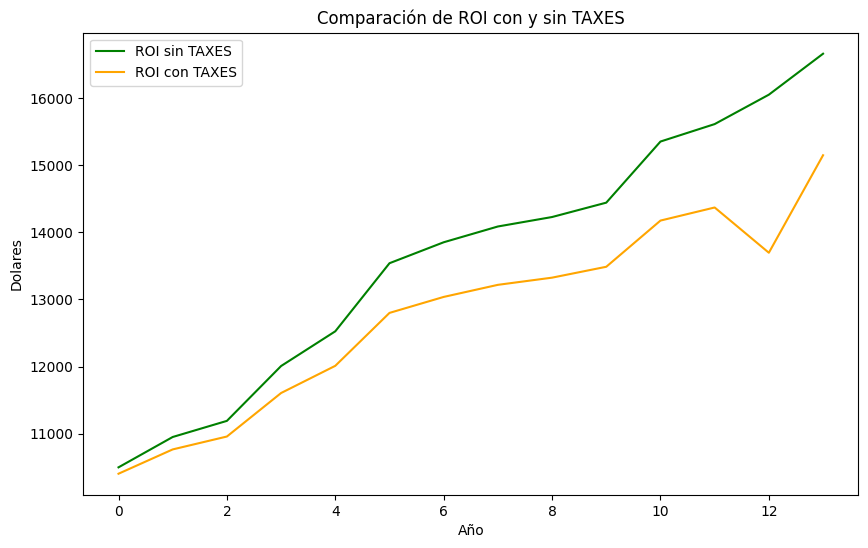

In [7]:
import matplotlib.pyplot as plt

# Listas de valores
lista_verde = [10500, 10952, 11192, 12009, 12526, 13540, 13852, 14087, 14228, 14442, 15352, 15612, 16050, 16660]
lista_naranja = [10405, 10767, 10959, 11607, 12012, 12800, 13038, 13218, 13325, 13487, 14175, 14370, 13696, 15148]

# Crear la gráfica
plt.figure(figsize=(10,6))

# Dibujar las líneas
plt.plot(lista_verde, color='green', label='ROI sin TAXES')
plt.plot(lista_naranja, color='orange', label='ROI con TAXES')

# Añadir títulos y leyendas
plt.title('Comparación de ROI con y sin TAXES')
plt.xlabel('Año')
plt.ylabel('Dolares')
plt.legend()

# Mostrar la gráfica
plt.show()
